In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

device = torch.device('cuda:0')
steps  = 51
pp   = torch.tensor(.8)
h    = torch.log(pp/(1-pp))/2
k    = 3
d    = 50000
bs   = 200
ts   = torch.linspace(0, 1, steps)
x    = torch.randn(d, bs, device=device)
xs   = [x]
inv_t  = 2
fp_eqn = lambda x: np.tanh(inv_t * x) - x 
m      = torch.tensor(newton(fp_eqn, 1))

tau  = lambda t: 2*k*t/d**(1/2) if t < 1/2 else k/d**(1/2) + (1-k/d**(1/2))*(2*t-1)
taup = lambda t: 2*k/d**(1/2) if t < 1/2 else (1-k/d**(1/2))*2

b_over_a = lambda t: tau(t) / (1-tau(t)**2)
W_plus   = torch.exp(h * m) / (2 * torch.cosh(h * m))
W_minus  = torch.exp(-h * m) / (2 * torch.cosh(h * m))
logQp    = lambda x, t: torch.sum(torch.log(1 + m * torch.tanh(x * b_over_a(t))), 0)
logQm    = lambda x, t: torch.sum(torch.log(1 - m * torch.tanh(x * b_over_a(t))), 0)

def cond_exp(x, t):
    # Q_p > Q_m
    pgm = logQp(x, t) >= logQm(x, t)
    Q_mp = torch.exp((logQm(x, t) - logQp(x, t)) * pgm)
    num = W_plus * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * Q_mp * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus + W_minus * Q_mp
    eta_mp = num / den
    
    # Q_m > Q_p
    mgp = logQp(x, t) < logQm(x, t)
    Q_pm = torch.exp((logQp(x, t) - logQm(x, t)) * mgp)
    num = W_plus * Q_pm * torch.tanh(inv_t * m + x * b_over_a(t))\
          + W_minus * torch.tanh(-inv_t * m + x * b_over_a(t)) 
    den = W_plus * Q_pm + W_minus
    eta_pm = num / den

    # put together
    return eta_mp * pgm + eta_pm * mgp

bf = lambda x, t: (-tau(t)*taup(t) * x + taup(t) * cond_exp(x, t))/(1-tau(t)**2)

for i, t in enumerate(ts[:-1]):
    if i % 10 == 0: print(t)
    dt = ts[i+1] - ts[i]
    x = x + bf(x, t) * dt
    xs.append(x)

xs = torch.stack(xs)

tensor(0.)
torch.Size([50000, 200])
torch.Size([50000, 200])
torch.Size([50000, 200])
torch.Size([50000, 200])
torch.Size([50000, 200])
torch.Size([50000, 200])
torch.Size([50000, 200])


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacity of 44.48 GiB of which 21.31 MiB is free. Process 4116604 has 38.20 GiB memory in use. Process 4193336 has 320.00 MiB memory in use. Process 4193461 has 5.21 GiB memory in use. Including non-PyTorch memory, this process has 750.00 MiB memory in use. Of the allocated memory 534.06 MiB is allocated by PyTorch, and 27.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [62]:
ms = xs.mean(1).cpu().numpy()

In [63]:
(ms[-1] > 0).mean()

np.float64(0.79)

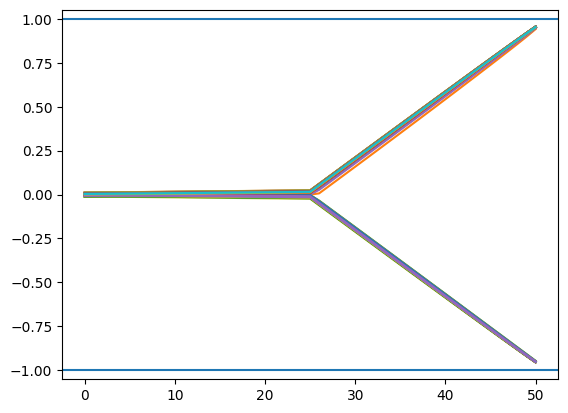

In [64]:
plt.plot(ms);
plt.axhline(1, 0, 200)
plt.axhline(-1, 0, 200)

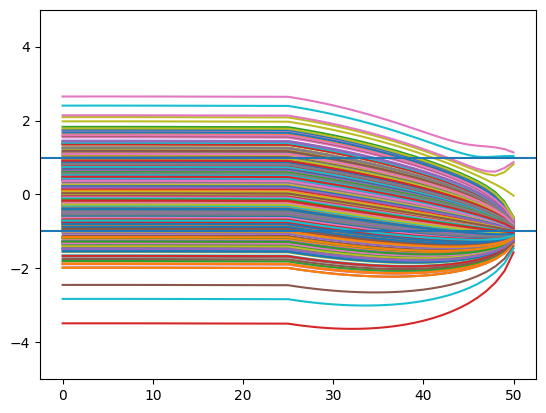

In [65]:
plt.plot(xs[:, :300, 1].cpu().numpy());
plt.ylim(-5,5)
plt.axhline(1, 0, 200)
plt.axhline(-1, 0, 200)

In [66]:
np.mean(xs[-1, :, 0].cpu().numpy() > 0)*2-1

np.float64(0.95112)

In [68]:
for i in range(steps): print(np.mean(xs[i, :, 0].cpu().numpy() > 0)*2-1)

-0.0019200000000000328
-0.0018799999999999928
-0.0015600000000000058
-0.0014399999999999968
-0.0013199999999999878
-0.0011200000000000099
-0.0009599999999999609
-0.0007599999999999829
-0.00048000000000003595
-0.00036000000000002697
-0.00012000000000000899
4.0000000000040004e-05
0.00015999999999993797
0.00043999999999999595
0.0005599999999998939
0.0007200000000000539
0.0009600000000000719
0.0012399999999999078
0.0014799999999999258
0.0019199999999999218
0.0023200000000000998
0.0029600000000000737
0.0033199999999999896
0.0036799999999999056
0.0040000000000000036
0.0043999999999999595
0.034319999999999906
0.06347999999999998
0.09396000000000004
0.1253200000000001
0.1559600000000001
0.18764000000000003
0.22076000000000007
0.25264
0.28635999999999995
0.31992
0.35627999999999993
0.39280000000000004
0.43096
0.47164000000000006
0.5140800000000001
0.5591200000000001
0.6064
0.6553199999999999
0.70932
0.76752
0.82264
0.8788800000000001
0.92252
0.94644
0.95112
